# Convolutional neural network regression model on fake data.

Creating a **CNN regressor from a CNN classifier by removing softmax function from the classifier’s output layer** and how to train it on a fake regression dataset.

## Fake regression data

In [3]:
import numpy as np
import pandas as pd

from braindecode.datasets import BaseConcatDataset, BaseDataset
from braindecode.util import create_mne_dummy_raw

In [4]:
def fake_regression_dataset(n_fake_recs, n_fake_chs, fake_sfreq,
                            fake_duration, n_fake_targets,
                            fake_data_split=[0.6, 0.2, 0.2]):
    """Generate a fake regression dataset.

    Parameters
    ----------
    n_fake_recs : int
        Number of fake recordings.
    n_fake_chs : int
        Number of fake EEG channels.
    fake_sfreq : float
        Fake sampling frequency in Hz.
    fake_duration : float
        Fake recording duration in seconds.
    n_fake_targets : int
        Number of targets.
    fake_data_split : list
        List of train/valid/test subset fractions.

    Returns
    -------
    dataset : BaseConcatDataset object
        The generated dataset object.
    """

    datasets = []
    for i in range(n_fake_recs):
        if i < int(fake_data_split[0] * n_fake_recs):
            target_subset = "train"
        elif i < int((1 - fake_data_split[2]) * n_fake_recs):
            target_subset = "valid"
        else:
            target_subset = "test"
        raw, _ = create_mne_dummy_raw(n_channels=n_fake_chs,
                                      n_times=fake_duration * fake_sfreq,
                                      sfreq=fake_sfreq)

        target = np.random.randint(0, 10, n_fake_targets)
        for j in range(n_fake_targets):
            x = np.sin(2 * np.pi * target[j] * raw.times)
            raw._data += np.expand_dims(x, axis=0)

        if n_fake_targets == 1:
            target = target[0]
        fake_description = pd.Series(data=[target, target_subset],
                                     index=["target", "session"])
        datasets.append(
            BaseDataset(raw, fake_description, target_name="target"))

    return BaseConcatDataset(datasets)

## Generating fake regression dataset

In [5]:
n_fake_rec = 20
n_fake_chans = 21
fake_sfreq = 100
fake_duration = 30
n_fake_targets = 1
dataset = fake_regression_dataset(n_fake_recs=n_fake_rec,
                                  n_fake_chs=n_fake_chans,
                                  fake_sfreq=fake_sfreq,
                                  fake_duration=fake_duration,
                                  n_fake_targets=n_fake_targets)

Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.

## Defining a CNN regression model
Choosing and defining a CNN classifier, ShallowFBCSPNet or Deep4Net, introduced in [1]. To convert a classifier to a regressor, softmax function is removed from its output layer.

In [6]:
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net
from braindecode.models import ShallowFBCSPNet
import torch

# Choosing a CNN model
model_name = "shallow"  # 'shallow' or 'deep'

# Defining a CNN model
if model_name in ["shallow", "Shallow", "ShallowConvNet"]:
    model = ShallowFBCSPNet(in_chans=n_fake_chans,
                            n_classes=n_fake_targets,
                            input_window_samples=fake_sfreq * fake_duration,
                            n_filters_time=40, n_filters_spat=40,
                            final_conv_length=35,
                            add_log_softmax=False,)
elif model_name in ["deep", "Deep", "DeepConvNet"]:
    model = Deep4Net(in_chans=n_fake_chans, n_classes=n_fake_targets,
                     input_window_samples=fake_sfreq * fake_duration,
                     n_filters_time=25, n_filters_spat=25,
                     stride_before_pool=True,
                     n_filters_2=n_fake_chans * 2,
                     n_filters_3=n_fake_chans * 4,
                     n_filters_4=n_fake_chans * 8,
                     final_conv_length=1,
                     add_log_softmax=False, )
else:
    raise ValueError(f'{model_name} unknown')

/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'in_chans' is depreciated. Use 'n_chans' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(


## Choosing between GPU and CPU processors

In [7]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

# Setting a random seed
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)
if cuda:
    model.cuda()

## Data windowing

In [8]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.preprocessing import create_fixed_length_windows

window_size_samples = fake_sfreq * fake_duration // 3
to_dense_prediction_model(model)
n_preds_per_input = get_output_shape(model, n_fake_chans, window_size_samples)[
    2]
windows_dataset = create_fixed_length_windows(dataset,
                                              start_offset_samples=0,
                                              stop_offset_samples=0,
                                              window_size_samples=window_size_samples,
                                              window_stride_samples=n_preds_per_input,
                                              drop_last_window=False,
                                              preload=True)

# Splitting windowed data into train, valid and test subsets.
splits = windows_dataset.split("session")
train_set = splits["train"]
valid_set = splits["valid"]
test_set = splits["test"]

/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function to_dense_prediction_model is deprecated; will be removed in version 1.0. Use EEGModuleMixin.to_dense_prediction_model method directly on the model object.
  warnings.warn(msg, category=FutureWarning)
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_output_shape is deprecated; will be removed in version 1.0. Use EEGModuleMixin.get_output_shape method directly on the model object.
  warnings.warn(msg, category=FutureWarning)
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/preprocessing/windowers.py:610: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


## Model training 
Model is trained by minimizing MSE loss between ground truth and estimated value averaged over a period of time using AdamW optimizer [2], [3]. Learning rate is managed by CosineAnnealingLR learning rate scheduler.

In [9]:
from braindecode import EEGRegressor
from braindecode.training.losses import CroppedLoss
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

batch_size = 4
n_epochs = 3
optimizer_lr = 0.001
optimizer_weight_decay = 0.0
regressor = EEGRegressor(model, cropped=True,
                         criterion=CroppedLoss,
                         criterion__loss_function=torch.nn.functional.mse_loss,
                         optimizer=torch.optim.AdamW,
                         optimizer__lr=optimizer_lr,
                         optimizer__weight_decay=optimizer_weight_decay,
                         train_split=predefined_split(valid_set),
                         iterator_train__shuffle=True,
                         batch_size=batch_size,
                         callbacks=["neg_root_mean_squared_error",
                                    ("lr_scheduler",
                                     LRScheduler('CosineAnnealingLR',
                                                 T_max=n_epochs - 1))],
                         device=device, )
regressor.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_loss    train_neg_root_mean_squared_error    valid_loss    valid_neg_root_mean_squared_error      lr     dur
-------  ------------  -----------------------------------  ------------  -----------------------------------  ------  ------
      1       13.9880                              -2.2767        1.7004                              -1.3047  0.0010  0.3392
      2        4.3530                              -1.1576        0.6596                              -0.8111  0.0005  0.3064
      3        3.1210                              -1.2162        1.0732                              -1.0336  0.0000  0.2894


## Model evaluation
Plotting training and validation losses and negative root mean square error

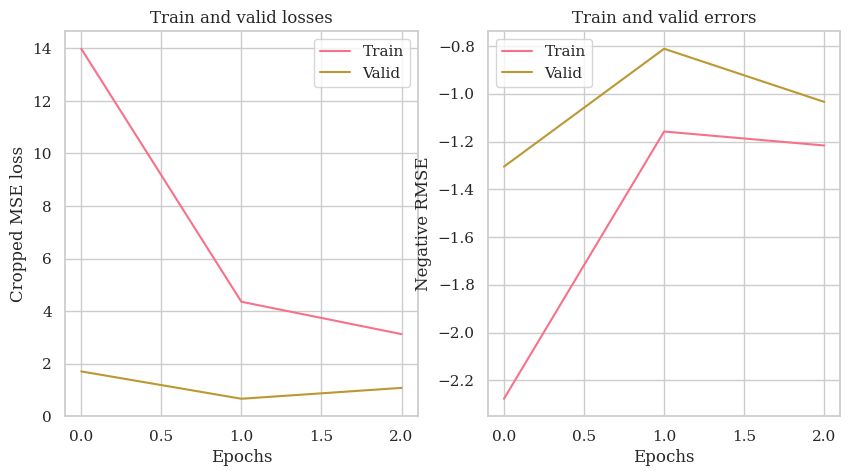

In [10]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Train and valid losses")
axes[0].plot(regressor.history[:, "train_loss"])
axes[0].plot(regressor.history[:, "valid_loss"])
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Cropped MSE loss")
axes[0].legend(["Train", "Valid"])

axes[1].set_title("Train and valid errors")
axes[1].plot(regressor.history[:, "train_neg_root_mean_squared_error"])
axes[1].plot(regressor.history[:, "valid_neg_root_mean_squared_error"])
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Negative RMSE")
axes[1].legend(["Train", "Valid"])

## Model testing plot

Scatter plot of estimated versus target values and correspondiong trend line.

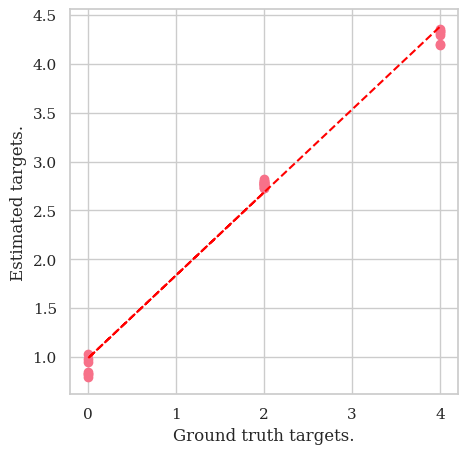

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
y_estim = np.ravel(regressor.predict(test_set))
y_gt = test_set.get_metadata()["target"].to_numpy()

_ = axes.scatter(y_gt, y_estim)
_ = axes.set_ylabel("Estimated targets.")
_ = axes.set_xlabel("Ground truth targets.")

z = np.polyfit(y_gt, y_estim, 1)
p = np.poly1d(z)
plt.plot(y_gt, p(y_gt), "r--")
plt.show()